In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

seed = 42
np.random.seed(seed=seed)

def train_generator(X_train, y_train, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []            
            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]
            for i in range(len(train_batch)):
                data, _ = librosa.load(train_batch[i], sr = SR)
                data = metamorphose(data, setting=setting)
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            y_batch = utils.to_categorical(y_batch, len(target_names))
            yield x_batch, y_batch

def valid_generator(X_val, y_val, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_val), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_val))
            test_batch = X_val[start:end]
            labels_batch = y_val[start:end]
            for i in range(len(test_batch)):
                data, _ = librosa.load(test_batch[i], sr = SR)
                data = metamorphose(data, setting=setting)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            y_batch = utils.to_categorical(y_batch, len(target_names))
            yield x_batch, y_batch
            
splitting = 'custom'
data_setting = 'stft'
model_setting = 'DenseNet121'

### Splitting mosquito data same way it was split to train

In [2]:
d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 5.24 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.39 seconds.
['20170212', '20170211', '20170209', '20170208', '20170210', '20170207', '20170213', '20161213', '20170206', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.40 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.39 seconds.
['20170131', '20170317', '20170318', '20170320', '20170205', '20170203', '20170204', '20170202', '20170319', '20170313', '20170201', '20170314', '20170316', '20170130', '20170206', '20170315']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.39 seconds.
['20170121', '20170120', '20170123', '20170118', '20170117', '20170119', '20170116', '20170122', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Rea

{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

### Loading MosquitoNet and removing its last 2 layers

In [3]:
merged = True

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# NOT LOADING MODELS
model.summary()

if data_setting in ['raw', 'rawflt','psd','psdflt', 'psd_dB','psd_dBflt']:
    # cut_mosquito_model is the model without its last dropout and softmax
    cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
elif data_setting in ['stft','stftflt']:
    cut_mosquito_model = Model(model.inputs, model.layers[-2].output)

############ INPUT SHAPE:(129, 120, 1)
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 120, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 135, 126, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 65, 60, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 65, 60, 64)   256         conv1/conv[0][0]                 
_________________________________________________

In [4]:
cut_mosquito_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 120, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 135, 126, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 65, 60, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 65, 60, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Reading Flies data and splitting into Train/Val/Test

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd
from wavhandler import *

In [6]:
dconf = Dataset('Pcfruit_sensor49')
dconf.read(loadmat=False);
dconf.get_sensor_features(temp_humd=False)
sub = dconf.df_features

mel_test_dates = ['20191216','20191217','20191220','20191221','20191222','20191223',
                 '20191224','20191225','20191226','20191227','20191228','20191229',
                 '20191230','20191231','20200101','20200102','20200103','20200104',
                 '20200105','20200106','20200107','20200108','20200109','20200110',
                 '20200111','20200112','20200113','20200114','20200115','20200116',
                 '20200117','20200118','20200119']
mel_val_dates = [['20200131','20200201'],['20200307'],['20200313','20200314','20200315','20200316']]
suz_test_dates = ['20200207', '20200208']
suz_val_dates = [['20200209'],['20200214'],['20200219']]

Species: all.
Read 10264 filenames in 0.25 seconds.


,filenames,wavnames,date,datestr,date_day,date_hour,gain,y
0,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200211_220602_243_G_050_T_28.7_H_60.4,2020-02-11 22:06:02,20200211,11,22,050,D. suzukii
1,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200218_142815_044_G_050_T_29.3_H_53.6,2020-02-18 14:28:15,20200218,18,14,050,D. suzukii
2,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200219_021355_158_G_050_T_29.3_H_55.0,2020-02-19 02:13:55,20200219,19,2,050,D. suzukii
3,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200218_214233_140_G_050_T_29.3_H_44.8,2020-02-18 21:42:33,20200218,18,21,050,D. suzukii
4,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200210_021538_074_G_050_T_29.3_H_57.5,2020-02-10 02:15:38,20200210,10,2,050,D. suzukii


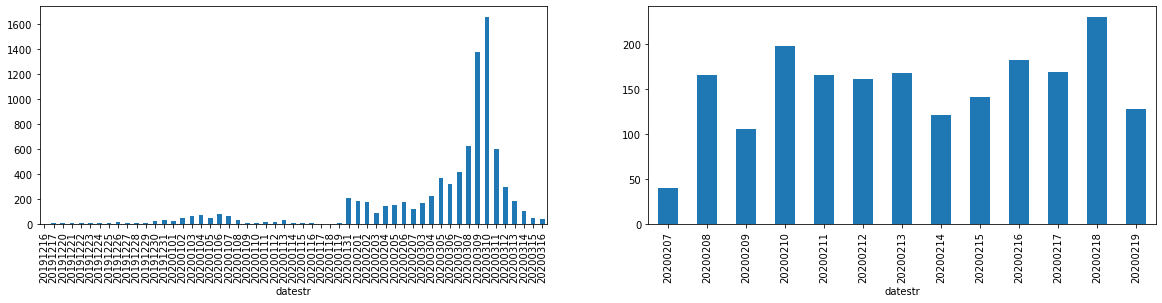

In [7]:
sub['y'] = dconf.df_features.filenames.apply(lambda x: x.split('/')[dconf.class_path_idx])
df_suz = sub[sub['y'] == 'D. suzukii']
df_mel = sub[sub['y'] == 'D. melanogaster']

plt.figure(figsize=(20,4))
plt.subplot(121); df_mel.groupby('datestr')['filenames'].count().plot(kind="bar")
plt.subplot(122); df_suz.groupby('datestr')['filenames'].count().plot(kind="bar")

df_suz.head()

In [8]:
mel_test = df_mel[df_mel.datestr.isin(mel_test_dates)][['filenames','y']]
suz_test = df_suz[df_suz.datestr.isin(suz_test_dates)][['filenames','y']]
# suz_test.sample(5)
# For the test set we made 1 dataframe for each insect species,
# but for the validation set we have a list of 3 dataframes for each species
# since we select three validation sets.
mel_val, suz_val = [],[]
for i in range(3):
    suz_val.append(df_suz[df_suz.datestr.isin(suz_val_dates[i])][['filenames','y']])
    mel_val.append(df_mel[df_mel.datestr.isin(mel_val_dates[i])][['filenames','y']])
# mel_val[0].sample(5)

lenc = LabelEncoder()
lenc.fit(dconf.y)

test = pd.concat([mel_test, suz_test])
Xf_test = test.filenames.tolist()
yf_test = lenc.transform(test.y).tolist()
# Trainval contains all data for training and validation sets [it excludes test set]
trainval = sub[~sub.filenames.isin(Xf_test)][['filenames','y']]
trainval.sample(5)

,filenames,y
2478,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
8448,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
2594,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
7832,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
8654,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster


In [26]:
pd.DataFrame({'fpaths': Xf_test, 'labels': yf_test})

,fpaths,labels
0,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,0
1,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,0
2,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,0
3,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,0
4,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,0
...,...,...
871,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,1
872,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,1
873,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,1
874,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,1


In [21]:
pd.DataFrame({'fpaths': Xf_test, 'labels': yf_test}).to_csv(f"{TEMP_DATADIR}/Test_data.csv", index=None)

# Function to create model, extract features and train

In [9]:
def create_top_model(input_shape=cut_mosquito_model.output_shape[1:]):
    ### Creating a shallow model to put on top of Mosquito model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_shape))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(2, activation='softmax'))
    top_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return top_model

def extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val, setting=data_setting):
    ### Passing fly data through the cut Mosquito model to get output
    ##### This output will be used to train the shallow model for few epochs

    Xf_xtracted_train = cut_mosquito_model.predict(valid_generator(Xf_train, 
                                                    yf_train, 
                                                    batch_size=128, 
                                                    setting=data_setting, 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_train)) / float(128))))

    Xf_xtracted_val = cut_mosquito_model.predict(valid_generator(Xf_val, 
                                                    yf_val, 
                                                    batch_size=128, 
                                                    setting=data_setting, 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_val)) / float(128))))    
    return Xf_xtracted_train, Xf_xtracted_val

def train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                cut_mosquito_model, top_model, frozen_layers=0):
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(yf_train), y=yf_train)
    class_weights = {i : weights[i] for i in range(2)}
    
    ### Training Shallow model for a few epochs
    traincf_flies = TrainConfiguration(dataset=dconf, setting=data_setting, monitor='val_accuracy', 
                                       model_name=f'top_model_flies', batch_size=32, epochs=5)
    top_model.fit(Xf_xtracted_train, yf_train, 
                  validation_data=(Xf_xtracted_val,yf_val),
                  batch_size=traincf_flies.batch_size, 
                  epochs=traincf_flies.epochs, 
                  callbacks=traincf_flies.callbacks_list,
                 class_weight=class_weights,
                 verbose=1);
    ### Freezing first few layers of MosquitoNet
    if frozen_layers > 0:
        for lay in cut_mosquito_model.layers[:frozen_layers]:
            lay.trainable = False
    ### Adding shallow model on top of the cut Mosquito model
    inputA = Input(cut_mosquito_model.input_shape[1:])
    outputA = cut_mosquito_model(inputA)
    outputB = top_model(outputA)
    modelC = Model(inputA, outputB)
    modelC.compile(loss='mse',
                  optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    ### Training MosquitoNet+Shallow
    traincf_flies = TrainConfiguration(dataset=dconf, setting=data_setting, monitor='val_accuracy', es_patience=4, rlr_patience=4, model_name=f'whole_model_flies', batch_size=32)
    h = modelC.fit(train_generator(Xf_train, yf_train, 
                                        batch_size=traincf_flies.batch_size,
                                        target_names=traincf_flies.target_names,
                                        setting=traincf_flies.setting),
                        steps_per_epoch = int(math.ceil(float(len(Xf_train)) / float(traincf_flies.batch_size))),
                        epochs = traincf_flies.epochs,
                        validation_data = valid_generator(Xf_val, yf_val,
                                                            batch_size=traincf_flies.batch_size,
                                                            target_names=traincf_flies.target_names,
                                                            setting=traincf_flies.setting),
                        validation_steps=int(math.ceil(float(len(Xf_test))/float(traincf_flies.batch_size))),
                        callbacks=traincf_flies.callbacks_list, 
                        class_weight=class_weights, 
                        verbose=1);

    yf_pred = modelC.predict(valid_generator(Xf_test, 
                            yf_test, 
                            batch_size=128, 
                            setting=data_setting, 
                            target_names=['suz','mel']),
                        steps = int(math.ceil(float(len(Xf_test)) / float(128))))
    return yf_pred, h, modelC


In [10]:
## DEBUGGING
# valfold_mel = trainval[trainval.filenames.isin(mel_val[valset].filenames)]
# valfold_suz = trainval[trainval.filenames.isin(suz_val[valset].filenames)]
# validation = pd.concat([valfold_mel, valfold_suz])
# Xf_val = validation.filenames.tolist()
# yf_val = lenc.transform(validation.y)

# train = trainval[~trainval.filenames.isin(validation.filenames)]
# train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
# Xf_train, yf_train = train_smpl.filenames.tolist(), lenc.transform(train_smpl.y)

# next(valid_generator(Xf_train, 
#                     yf_train, 
#                     batch_size=128, 
#                     setting='raw', 
#                     target_names=['suz','mel']))[0].shape

In [11]:
# smpl = 1000#[100, 175, 250, 325, 400, 500, 1000, 2000, 4000, 6000, 8000]
# frozen_layers = 19 #[0, 5, 15, 19]
# trial = 0 #[0,1,2,3,4,5,6,7,8,9]
# valset = 0

# savepath = f'../temp_data/{data_setting}_merged{merged}_nr{frozen_layers}_samples{smpl}_val{valset}_trial{trial}.csv'
# print(savepath)

# print(f'\n\n###########\nNOW USING {smpl} SAMPLES in {valset} VALIDATION FOLD\n##############')
# smpl_results = {}

# valfold_mel = trainval[trainval.filenames.isin(mel_val[valset].filenames)]
# valfold_suz = trainval[trainval.filenames.isin(suz_val[valset].filenames)]
# validation = pd.concat([valfold_mel, valfold_suz])
# Xf_val = validation.filenames.tolist()
# yf_val = lenc.transform(validation.y)

# train = trainval[~trainval.filenames.isin(validation.filenames)]
# train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
# Xf_train, yf_train = train_smpl.filenames.tolist(), lenc.transform(train_smpl.y)

# print(f"Train: \n{pd.Series(yf_train).value_counts()}")
# print(f"Val: \n{pd.Series(yf_val).value_counts()}")
# print(f"Test: \n{pd.Series(yf_test).value_counts()}")    

# # cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
# top_model = create_top_model(input_shape=cut_mosquito_model.output_shape[1:])
# Xf_xtracted_train, Xf_xtracted_val = extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val)
# # yf_pred, h, modelC = train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
# #                                  cut_mosquito_model, top_model, frozen_layers=frozen_layers)

# weights = class_weight.compute_class_weight('balanced', classes=np.unique(yf_train), y=yf_train)
# class_weights = {i : weights[i] for i in range(2)}

# ### Training Shallow model for a few epochs
# traincf_flies = TrainConfiguration(dataset=dconf, setting=data_setting, monitor='val_accuracy', 
#                                    model_name=f'top_model_flies', batch_size=32, epochs=10)

# top_model.fit(Xf_xtracted_train, yf_train, 
#               validation_data=(Xf_xtracted_val,yf_val),
#               batch_size=traincf_flies.batch_size, 
#               epochs=traincf_flies.epochs, 
# #               callbacks=traincf_flies.callbacks_list,
#              class_weight=class_weights,
#              verbose=1)

# ### Freezing first few layers of MosquitoNet
# if frozen_layers > 0:
#     for lay in cut_mosquito_model.layers[:frozen_layers]:
#         lay.trainable = False
# ### Adding shallow model on top of the cut Mosquito model
# inputA = Input(cut_mosquito_model.input_shape[1:])
# outputA = cut_mosquito_model(inputA)
# outputB = top_model(outputA)
# modelC = Model(inputA, outputB)
# modelC.compile(loss='binary_crossentropy',
#               optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
#               metrics=['accuracy'])
# ### Training MosquitoNet+Shallow
# traincf_flies = TrainConfiguration(dataset=dconf, setting=data_setting, monitor='val_accuracy', es_patience=4, rlr_patience=4, model_name=f'whole_model_flies', batch_size=32)

# h = modelC.fit(train_generator(Xf_train, yf_train, 
#                                     batch_size=traincf_flies.batch_size,
#                                     target_names=traincf_flies.target_names,
#                                     setting=traincf_flies.setting),
#                     steps_per_epoch = int(math.ceil(float(len(Xf_train)) / float(traincf_flies.batch_size))),
#                     epochs = traincf_flies.epochs,
#                     validation_data = valid_generator(Xf_val, yf_val,
#                                                         batch_size=traincf_flies.batch_size,
#                                                         target_names=traincf_flies.target_names,
#                                                         setting=traincf_flies.setting),
#                     validation_steps=int(math.ceil(float(len(Xf_test))/float(traincf_flies.batch_size))),
#                     callbacks=traincf_flies.callbacks_list, 
#                     class_weight=class_weights, 
#                     verbose=1)

In [12]:
def myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=0, frozen_layers=0, smpl=100, valset=0):
    savepath = f'../temp_data/{data_setting}_merged{merged}_nr{frozen_layers}_samples{smpl}_val{valset}_trial{trial}.csv'
    print(savepath)
    if os.path.isfile(savepath):
        print("ALREADY EXISTS")
        return

    print(f'\n\n###########\nNOW USING {smpl} SAMPLES in {valset} VALIDATION FOLD\n##############')
    smpl_results = {}

    valfold_mel = trainval[trainval.filenames.isin(mel_val[valset].filenames)]
    valfold_suz = trainval[trainval.filenames.isin(suz_val[valset].filenames)]
    validation = pd.concat([valfold_mel, valfold_suz])
    Xf_val = validation.filenames.tolist()
    yf_val = lenc.transform(validation.y)

    train = trainval[~trainval.filenames.isin(validation.filenames)]
    train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
    Xf_train, yf_train = train_smpl.filenames.tolist(), lenc.transform(train_smpl.y)

    print(f"Train: \n{pd.Series(yf_train).value_counts()}")
    print(f"Val: \n{pd.Series(yf_val).value_counts()}")
    print(f"Test: \n{pd.Series(yf_test).value_counts()}")    

    # cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
    top_model = create_top_model(input_shape=cut_mosquito_model.output_shape[1:])
    Xf_xtracted_train, Xf_xtracted_val = extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val)
    yf_pred, h, modelC = train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                                     cut_mosquito_model, top_model, frozen_layers=frozen_layers)

    lb = LabelBinarizer()
    yf_pred_argmax = np.argmax(yf_pred, axis=1)
    cm = confusion_matrix(yf_test, yf_pred_argmax).astype(float)
    smpl_results['yf_test'] = yf_test
    smpl_results['yf_pred'] = yf_pred
    smpl_results['yf_pred_argmax'] = yf_pred_argmax
    smpl_results['nr_samples'] = smpl
    smpl_results['trial'] = trial
    smpl_results['frozen_layers'] = frozen_layers
    smpl_results['accuracy_score'] = accuracy_score(yf_test, yf_pred_argmax)
    smpl_results['balanced_accuracy_score'] = balanced_accuracy_score(yf_test, yf_pred_argmax)
    smpl_results['cm'] = cm
    #     smpl_results['classification_report'] = classification_report(yf_test, yf_pred_argmax)
    smpl_results['history'] = h.history

    dd.io.save(savepath, smpl_results)
    print('Done.')

In [ ]:
samples = [100, 175, 250, 325, 400, 500, 1000, 2000, 4000, 6000, 8000]
froz_layerlist = [0, 19] #5, 15, 19]
trials = [0,1,2,3,4,5,6,7,8,9]

for trial in trials:
    for frozen_layers in froz_layerlist:
        for valset in range(3):
            for smpl in samples:
                myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=trial, frozen_layers=frozen_layers, smpl=smpl, valset=valset)

../temp_data/stft_mergedTrue_nr0_samples100_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples175_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples250_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples325_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples400_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples500_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples1000_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples2000_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples4000_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples6000_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples8000_val0_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples100_val1_trial0.csv
ALREADY EXISTS
../temp_data/stft_mergedTrue_nr0_samples175_val1_trial0.csv
ALREADY EXISTS
../temp_data/stft_me

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples325_val1_trial2.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/11 [=>............................] - ETA: 0s - loss: 1.0787 - accuracy: 0.6562
Epoch 00001: val_accuracy improved from -inf to 0.29026, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
11/11 [==============================] - 0s 10ms/step - loss: 0.8797 - accuracy: 0.4677 - val_loss: 0.6979 - val_accuracy: 0.2903 - lr: 0.0010
Epoch 2/5
 1/11 [=>............................] - ETA: 0s - loss: 0.8796 - accuracy: 0.5312
Epoch 00002: val_accuracy improved from 0.29026 to 0.67416, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
11/11 [==============================] - 0s 6ms/step - loss: 0.8431 - accuracy: 0.4892 - val_loss: 0.6985 - val_accuracy

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples400_val1_trial2.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/13 [=>............................] - ETA: 0s - loss: 0.6058 - accuracy: 0.8438
Epoch 00001: val_accuracy improved from -inf to 0.32584, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
13/13 [==============================] - 0s 9ms/step - loss: 0.8412 - accuracy: 0.6325 - val_loss: 0.6972 - val_accuracy: 0.3258 - lr: 0.0010
Epoch 2/5
 1/13 [=>............................] - ETA: 0s - loss: 0.8511 - accuracy: 0.5625
Epoch 00002: val_accuracy did not improve from 0.32584
13/13 [==============================] - 0s 5ms/step - loss: 0.7877 - accuracy: 0.3250 - val_loss: 0.7042 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 3/5
 1/13 [=>............................] - ETA: 0s - loss: 0.8941 -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples500_val1_trial2.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/16 [>.............................] - ETA: 0s - loss: 0.8507 - accuracy: 0.4062
Epoch 00001: val_accuracy improved from -inf to 0.23596, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
16/16 [==============================] - 0s 8ms/step - loss: 0.9928 - accuracy: 0.4960 - val_loss: 0.7482 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 2/5
 1/16 [>.............................] - ETA: 0s - loss: 1.1096 - accuracy: 0.3438
Epoch 00002: val_accuracy improved from 0.23596 to 0.38764, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
16/16 [==============================] - 0s 4ms/step - loss: 1.0013 - accuracy: 0.5220 - val_loss: 0.7029 - val_accuracy:

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples1000_val1_trial2.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
28/32 [=========================>....] - ETA: 0s - loss: 0.8606 - accuracy: 0.4542
Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
32/32 [==============================] - 0s 4ms/step - loss: 0.8664 - accuracy: 0.4800 - val_loss: 0.7320 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 2/5
28/32 [=========================>....] - ETA: 0s - loss: 0.8374 - accuracy: 0.4978
Epoch 00002: val_accuracy did not improve from 0.77341
32/32 [==============================] - 0s 3ms/step - loss: 0.8441 - accuracy: 0.4950 - val_loss: 0.7051 - val_accuracy: 0.2322 - lr: 0.0010
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.8178

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples2000_val1_trial2.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
61/63 [============================>.] - ETA: 0s - loss: 0.7874 - accuracy: 0.4862
Epoch 00001: val_accuracy improved from -inf to 0.88015, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
63/63 [==============================] - 0s 3ms/step - loss: 0.7879 - accuracy: 0.4885 - val_loss: 0.7171 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 2/5
32/63 [==============>...............] - ETA: 0s - loss: 0.7763 - accuracy: 0.5498
Epoch 00002: val_accuracy did not improve from 0.88015
63/63 [==============================] - 0s 2ms/step - loss: 0.7699 - accuracy: 0.5245 - val_loss: 0.7044 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 3/5
60/63 [===========================>..] - ETA: 0s - loss: 0.74

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples4000_val1_trial2.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
108/125 [========================>.....] - ETA: 0s - loss: 0.7680 - accuracy: 0.5041
Epoch 00001: val_accuracy improved from -inf to 0.02247, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
125/125 [==============================] - 0s 2ms/step - loss: 0.7657 - accuracy: 0.5060 - val_loss: 0.7032 - val_accuracy: 0.0225 - lr: 0.0010
Epoch 2/5
108/125 [========================>.....] - ETA: 0s - loss: 0.7325 - accuracy: 0.4876
Epoch 00002: val_accuracy improved from 0.02247 to 0.71910, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
125/125 [==============================] - 0s 2ms/step - loss: 0.7306 - accuracy: 0.4975 - val_loss: 0.6956 - v

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples6000_val1_trial2.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
188/188 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.5100
Epoch 00001: val_accuracy improved from -inf to 0.31648, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
188/188 [==============================] - 0s 2ms/step - loss: 0.7167 - accuracy: 0.5100 - val_loss: 0.6935 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 2/5
160/188 [========================>.....] - ETA: 0s - loss: 0.6994 - accuracy: 0.4996
Epoch 00002: val_accuracy improved from 0.31648 to 0.77715, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
188/188 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.5060 - val_loss: 0.6932 - v

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples8000_val1_trial2.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
228/250 [==========================>...] - ETA: 0s - loss: 0.8090 - accuracy: 0.5023
Epoch 00001: val_accuracy improved from -inf to 0.60487, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.8097 - accuracy: 0.5042 - val_loss: 0.6957 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 2/5
227/250 [==========================>...] - ETA: 0s - loss: 0.7285 - accuracy: 0.5076
Epoch 00002: val_accuracy did not improve from 0.60487
250/250 [==============================] - 0s 1ms/step - loss: 0.7265 - accuracy: 0.5055 - val_loss: 0.6949 - val_accuracy: 0.2303 - lr: 0.0010
Epoch 3/5
227/250 [==========================>...] - ETA: 0s - 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples100_val2_trial2.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/4 [======>.......................] - ETA: 0s - loss: 1.2611 - accuracy: 0.4062
Epoch 00001: val_accuracy improved from -inf to 0.31612, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
4/4 [==============================] - 0s 25ms/step - loss: 1.0661 - accuracy: 0.3600 - val_loss: 0.7760 - val_accuracy: 0.3161 - lr: 0.0010
Epoch 2/5
1/4 [======>.......................] - ETA: 0s - loss: 1.0038 - accuracy: 0.3438
Epoch 00002: val_accuracy improved from 0.31612 to 0.51033, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
4/4 [==============================] - 0s 13ms/step - loss: 1.1045 - accuracy: 0.3800 - val_loss: 0.8265 - val_accuracy: 0.5103 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples175_val2_trial2.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/6 [====>.........................] - ETA: 0s - loss: 0.8475 - accuracy: 0.8125
Epoch 00001: val_accuracy improved from -inf to 0.04545, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
6/6 [==============================] - 0s 17ms/step - loss: 0.8449 - accuracy: 0.5314 - val_loss: 0.7612 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 2/5
1/6 [====>.........................] - ETA: 0s - loss: 0.8023 - accuracy: 0.3438
Epoch 00002: val_accuracy improved from 0.04545 to 0.46694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
6/6 [==============================] - 0s 10ms/step - loss: 0.8642 - accuracy: 0.3429 - val_loss: 0.6961 - val_accuracy: 0.466

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples250_val2_trial2.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/8 [==>...........................] - ETA: 0s - loss: 0.6441 - accuracy: 0.5312
Epoch 00001: val_accuracy improved from -inf to 0.18182, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
8/8 [==============================] - 0s 13ms/step - loss: 0.7387 - accuracy: 0.5280 - val_loss: 0.6953 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 2/5
1/8 [==>...........................] - ETA: 0s - loss: 0.7053 - accuracy: 0.4062
Epoch 00002: val_accuracy did not improve from 0.18182
8/8 [==============================] - 0s 7ms/step - loss: 0.7676 - accuracy: 0.4680 - val_loss: 0.6979 - val_accuracy: 0.0888 - lr: 0.0010
Epoch 3/5
1/8 [==>...........................] - ETA: 0s - loss: 0.7443 - accuracy

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples325_val2_trial2.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/11 [=>............................] - ETA: 0s - loss: 1.1489 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.96488, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
11/11 [==============================] - 0s 10ms/step - loss: 0.8310 - accuracy: 0.5015 - val_loss: 0.7073 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 2/5
 1/11 [=>............................] - ETA: 0s - loss: 0.8739 - accuracy: 0.5938
Epoch 00002: val_accuracy did not improve from 0.96488
11/11 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 0.4062 - val_loss: 0.6964 - val_accuracy: 0.3471 - lr: 0.0010
Epoch 3/5
 1/11 [=>............................] - ETA: 0s - loss: 0.7970 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples400_val2_trial2.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/13 [=>............................] - ETA: 0s - loss: 0.6392 - accuracy: 0.3125
Epoch 00001: val_accuracy improved from -inf to 0.24174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
13/13 [==============================] - 0s 9ms/step - loss: 0.7996 - accuracy: 0.4825 - val_loss: 0.7044 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 2/5
 1/13 [=>............................] - ETA: 0s - loss: 0.9435 - accuracy: 0.3750
Epoch 00002: val_accuracy did not improve from 0.24174
13/13 [==============================] - 0s 4ms/step - loss: 0.8171 - accuracy: 0.5300 - val_loss: 0.7064 - val_accuracy: 0.1880 - lr: 0.0010
Epoch 3/5
 1/13 [=>............................] - ETA: 0s - loss: 0.8434 -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples500_val2_trial2.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/16 [>.............................] - ETA: 0s - loss: 0.8977 - accuracy: 0.4688
Epoch 00001: val_accuracy improved from -inf to 0.44421, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
16/16 [==============================] - 0s 7ms/step - loss: 0.7598 - accuracy: 0.5220 - val_loss: 0.6993 - val_accuracy: 0.4442 - lr: 0.0010
Epoch 2/5
 1/16 [>.............................] - ETA: 0s - loss: 0.7106 - accuracy: 0.4688
Epoch 00002: val_accuracy improved from 0.44421 to 0.72727, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
16/16 [==============================] - 0s 4ms/step - loss: 0.7370 - accuracy: 0.5200 - val_loss: 0.6957 - val_accuracy:

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples1000_val2_trial2.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
27/32 [========================>.....] - ETA: 0s - loss: 0.8029 - accuracy: 0.4977
Epoch 00001: val_accuracy improved from -inf to 0.40083, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
32/32 [==============================] - 0s 4ms/step - loss: 0.7876 - accuracy: 0.5010 - val_loss: 0.6973 - val_accuracy: 0.4008 - lr: 0.0010
Epoch 2/5
28/32 [=========================>....] - ETA: 0s - loss: 0.7748 - accuracy: 0.4888
Epoch 00002: val_accuracy improved from 0.40083 to 0.88430, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
32/32 [==============================] - 0s 3ms/step - loss: 0.7792 - accuracy: 0.4910 - val_loss: 0.6974 - val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples2000_val2_trial2.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
57/63 [==========================>...] - ETA: 0s - loss: 0.7778 - accuracy: 0.5082
Epoch 00001: val_accuracy improved from -inf to 0.12810, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
63/63 [==============================] - 0s 3ms/step - loss: 0.7876 - accuracy: 0.5075 - val_loss: 0.6952 - val_accuracy: 0.1281 - lr: 0.0010
Epoch 2/5
59/63 [===========================>..] - ETA: 0s - loss: 0.7610 - accuracy: 0.5117
Epoch 00002: val_accuracy did not improve from 0.12810
63/63 [==============================] - 0s 2ms/step - loss: 0.7570 - accuracy: 0.5025 - val_loss: 0.7018 - val_accuracy: 0.0103 - lr: 0.0010
Epoch 3/5
31/63 [=============>................] - ETA: 0s - loss: 0.74

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples4000_val2_trial2.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
105/125 [========================>.....] - ETA: 0s - loss: 0.7983 - accuracy: 0.5063
Epoch 00001: val_accuracy improved from -inf to 0.90083, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
125/125 [==============================] - 0s 2ms/step - loss: 0.7910 - accuracy: 0.5055 - val_loss: 0.6950 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 2/5
112/125 [=========================>....] - ETA: 0s - loss: 0.7425 - accuracy: 0.4997
Epoch 00002: val_accuracy did not improve from 0.90083
125/125 [==============================] - 0s 2ms/step - loss: 0.7397 - accuracy: 0.5008 - val_loss: 0.7033 - val_accuracy: 0.1384 - lr: 0.0010
Epoch 3/5
107/125 [========================>.....] - ETA: 0s - 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples6000_val2_trial2.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
155/188 [=======================>......] - ETA: 0s - loss: 0.7715 - accuracy: 0.4940
Epoch 00001: val_accuracy improved from -inf to 0.33264, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
188/188 [==============================] - 0s 2ms/step - loss: 0.7637 - accuracy: 0.4968 - val_loss: 0.7021 - val_accuracy: 0.3326 - lr: 0.0010
Epoch 2/5
187/188 [============================>.] - ETA: 0s - loss: 0.7152 - accuracy: 0.4945
Epoch 00002: val_accuracy did not improve from 0.33264
188/188 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.4938 - val_loss: 0.6963 - val_accuracy: 0.2624 - lr: 0.0010
Epoch 3/5
163/188 [=========================>....] - ETA: 0s - 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr0_samples8000_val2_trial2.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
218/250 [=========================>....] - ETA: 0s - loss: 0.7197 - accuracy: 0.4966
Epoch 00001: val_accuracy improved from -inf to 0.92975, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.7191 - accuracy: 0.5026 - val_loss: 0.6946 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 2/5
237/250 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.4847
Epoch 00002: val_accuracy improved from 0.92975 to 0.96901, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
250/250 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.4879 - val_loss: 0.6942 - v

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples100_val0_trial2.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/4 [======>.......................] - ETA: 0s - loss: 1.2592 - accuracy: 0.4062
Epoch 00001: val_accuracy improved from -inf to 0.15822, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
4/4 [==============================] - 0s 24ms/step - loss: 1.0790 - accuracy: 0.6100 - val_loss: 0.7325 - val_accuracy: 0.1582 - lr: 0.0010
Epoch 2/5
1/4 [======>.......................] - ETA: 0s - loss: 1.3493 - accuracy: 0.3125
Epoch 00002: val_accuracy did not improve from 0.15822
4/4 [==============================] - 0s 11ms/step - loss: 1.1582 - accuracy: 0.2800 - val_loss: 0.7218 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 3/5
1/4 [======>.......................] - ETA: 0s - loss: 0.9191 - accuracy

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples175_val0_trial2.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/6 [====>.........................] - ETA: 0s - loss: 2.2965 - accuracy: 0.3438
Epoch 00001: val_accuracy improved from -inf to 0.91278, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
6/6 [==============================] - 0s 17ms/step - loss: 1.3570 - accuracy: 0.3314 - val_loss: 0.7328 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 2/5
1/6 [====>.........................] - ETA: 0s - loss: 1.1999 - accuracy: 0.5625
Epoch 00002: val_accuracy did not improve from 0.91278
6/6 [==============================] - 0s 8ms/step - loss: 1.0978 - accuracy: 0.6857 - val_loss: 0.7173 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 3/5
1/6 [====>.........................] - ETA: 0s - loss: 1.1294 - accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples250_val0_trial2.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/8 [==>...........................] - ETA: 0s - loss: 0.8649 - accuracy: 0.5938
Epoch 00001: val_accuracy improved from -inf to 0.51521, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
8/8 [==============================] - 0s 13ms/step - loss: 0.8165 - accuracy: 0.4920 - val_loss: 0.7094 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 2/5
1/8 [==>...........................] - ETA: 0s - loss: 0.5927 - accuracy: 0.7188
Epoch 00002: val_accuracy did not improve from 0.51521
8/8 [==============================] - 0s 6ms/step - loss: 0.8164 - accuracy: 0.5240 - val_loss: 0.6994 - val_accuracy: 0.1765 - lr: 0.0010
Epoch 3/5
1/8 [==>...........................] - ETA: 0s - loss: 0.7607 - accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples325_val0_trial2.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/11 [=>............................] - ETA: 0s - loss: 0.7380 - accuracy: 0.5625
Epoch 00001: val_accuracy improved from -inf to 0.41582, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
11/11 [==============================] - 0s 10ms/step - loss: 0.8078 - accuracy: 0.4615 - val_loss: 0.7243 - val_accuracy: 0.4158 - lr: 0.0010
Epoch 2/5
 1/11 [=>............................] - ETA: 0s - loss: 0.8085 - accuracy: 0.4062
Epoch 00002: val_accuracy improved from 0.41582 to 0.72414, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
11/11 [==============================] - 0s 6ms/step - loss: 0.7963 - accuracy: 0.5631 - val_loss: 0.7231 - val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples400_val0_trial2.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/13 [=>............................] - ETA: 0s - loss: 0.9824 - accuracy: 0.3438
Epoch 00001: val_accuracy improved from -inf to 0.44625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.8777 - accuracy: 0.4625 - val_loss: 0.7022 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 2/5
 1/13 [=>............................] - ETA: 0s - loss: 0.6764 - accuracy: 0.2812
Epoch 00002: val_accuracy did not improve from 0.44625
13/13 [==============================] - 0s 5ms/step - loss: 0.8200 - accuracy: 0.5150 - val_loss: 0.7239 - val_accuracy: 0.4341 - lr: 0.0010
Epoch 3/5
 1/13 [=>............................] - ETA: 0s - loss: 0.7272 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples500_val0_trial2.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
 1/16 [>.............................] - ETA: 0s - loss: 0.9320 - accuracy: 0.3125
Epoch 00001: val_accuracy improved from -inf to 0.73631, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
16/16 [==============================] - 0s 7ms/step - loss: 0.8474 - accuracy: 0.5100 - val_loss: 0.6975 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/5
 1/16 [>.............................] - ETA: 0s - loss: 0.8408 - accuracy: 0.4688
Epoch 00002: val_accuracy did not improve from 0.73631
16/16 [==============================] - 0s 4ms/step - loss: 0.8601 - accuracy: 0.4940 - val_loss: 0.7074 - val_accuracy: 0.2880 - lr: 0.0010
Epoch 3/5
 1/16 [>.............................] - ETA: 0s - loss: 0.8383 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples1000_val0_trial2.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
24/32 [=====================>........] - ETA: 0s - loss: 0.8282 - accuracy: 0.4935
Epoch 00001: val_accuracy improved from -inf to 0.27383, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
32/32 [==============================] - 0s 5ms/step - loss: 0.8460 - accuracy: 0.4940 - val_loss: 0.6977 - val_accuracy: 0.2738 - lr: 0.0010
Epoch 2/5
26/32 [=======================>......] - ETA: 0s - loss: 0.8100 - accuracy: 0.5120
Epoch 00002: val_accuracy improved from 0.27383 to 0.42191, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
32/32 [==============================] - 0s 3ms/step - loss: 0.8221 - accuracy: 0.5050 - val_loss: 0.6943 - val_accura

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples2000_val0_trial2.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
54/63 [========================>.....] - ETA: 0s - loss: 0.8157 - accuracy: 0.5029
Epoch 00001: val_accuracy improved from -inf to 0.08722, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
63/63 [==============================] - 0s 3ms/step - loss: 0.8089 - accuracy: 0.4965 - val_loss: 0.6956 - val_accuracy: 0.0872 - lr: 0.0010
Epoch 2/5
55/63 [=========================>....] - ETA: 0s - loss: 0.7892 - accuracy: 0.5153
Epoch 00002: val_accuracy improved from 0.08722 to 0.78296, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
63/63 [==============================] - 0s 3ms/step - loss: 0.7820 - accuracy: 0.5070 - val_loss: 0.6988 - val_accu

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples4000_val0_trial2.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
104/125 [=======================>......] - ETA: 0s - loss: 0.8198 - accuracy: 0.4991
Epoch 00001: val_accuracy improved from -inf to 0.68357, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
125/125 [==============================] - 0s 2ms/step - loss: 0.8079 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 2/5
105/125 [========================>.....] - ETA: 0s - loss: 0.7575 - accuracy: 0.5051
Epoch 00002: val_accuracy improved from 0.68357 to 0.69371, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
125/125 [==============================] - 0s 2ms/step - loss: 0.7533 - accuracy: 0.5013 - val_loss: 0.6936 - 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples6000_val0_trial2.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
158/188 [========================>.....] - ETA: 0s - loss: 0.8654 - accuracy: 0.5024
Epoch 00001: val_accuracy improved from -inf to 0.69574, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
188/188 [==============================] - 0s 2ms/step - loss: 0.8542 - accuracy: 0.5008 - val_loss: 0.6943 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 2/5
156/188 [=======================>......] - ETA: 0s - loss: 0.7468 - accuracy: 0.5064
Epoch 00002: val_accuracy did not improve from 0.69574
188/188 [==============================] - 0s 2ms/step - loss: 0.7505 - accuracy: 0.5010 - val_loss: 0.6956 - val_accuracy: 0.2211 - lr: 0.0010
Epoch 3/5
158/188 [========================>.....] - ETA: 0s -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples8000_val0_trial2.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
216/250 [========================>.....] - ETA: 0s - loss: 0.8109 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.45842, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
250/250 [==============================] - 0s 2ms/step - loss: 0.8060 - accuracy: 0.4997 - val_loss: 0.6961 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 2/5
224/250 [=========================>....] - ETA: 0s - loss: 0.7291 - accuracy: 0.4946
Epoch 00002: val_accuracy did not improve from 0.45842
250/250 [==============================] - 0s 1ms/step - loss: 0.7265 - accuracy: 0.4965 - val_loss: 0.6939 - val_accuracy: 0.1927 - lr: 0.0010
Epoch 3/5
236/250 [===========================>..] - ETA: 0s -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/stft_mergedTrue_nr19_samples100_val1_trial2.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64
Epoch 1/5
1/4 [======>.......................] - ETA: 0s - loss: 0.6807 - accuracy: 0.4375
Epoch 00001: val_accuracy improved from -inf to 0.83146, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
4/4 [==============================] - 0s 24ms/step - loss: 0.7859 - accuracy: 0.4800 - val_loss: 0.7010 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 2/5
1/4 [======>.......................] - ETA: 0s - loss: 0.7863 - accuracy: 0.5625
Epoch 00002: val_accuracy did not improve from 0.83146
4/4 [==============================] - 0s 11ms/step - loss: 0.7623 - accuracy: 0.4800 - val_loss: 0.7111 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 3/5
1/4 [======>.......................] - ETA: 0s - loss: 0.6879 - accuracy